In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pdb

# I merged 2014, 2015, and 2016 data together. The file location is in the below cell.

In [2]:
df_pickle = '/home/lashi/assets/clean-data/merged_141516.pickle'
df = pd.read_pickle(df_pickle).reset_index(drop=True)

# Checking the distribution of pickups within a given region.
## I'm doing this to make sure that the data we're trying to cluster works best with kmeans.

### When we give our presentation we can give a narrative. We didn't dive right into kmeans. We looked at the data and decided which clustering option worked best.

In [4]:
pickup_table = '/home/lashi/assets/taxi_zones/taxi_zone_lookup.csv'
taxi_zone_df = pd.read_csv(pickup_table)

print(taxi_zone_df.head())

   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone


In [7]:
df1 = df.groupby(['pickup_id','pickup_merc_x_y']).size().reset_index()

## I'm randomly sampling 10 ids to get a rough idea of the types of distributions I should expect. 

In [8]:
sample_size = 10
id_points_to_plot = np.random.choice(df1.pickup_id.unique(), sample_size)
print(id_points_to_plot.tolist())

[181.0, 129.0, 139.0, 190.0, 250.0, 162.0, 49.0, 209.0, 59.0, 244.0]


Park Slope, Brooklyn


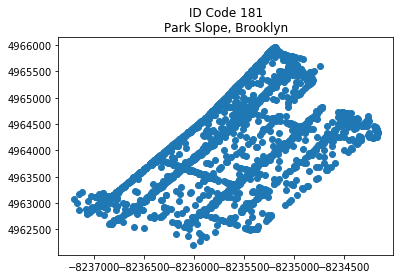

Jackson Heights, Queens


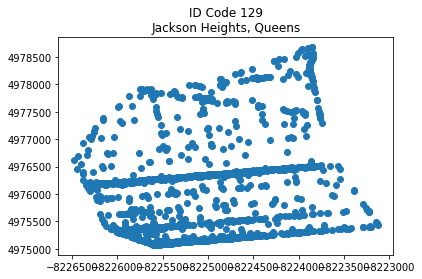

Laurelton, Queens


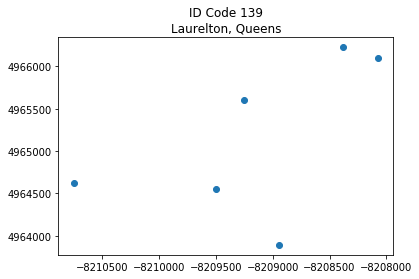

Prospect Park, Brooklyn


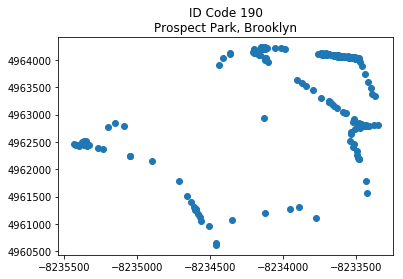

Westchester Village/Unionport, Bronx


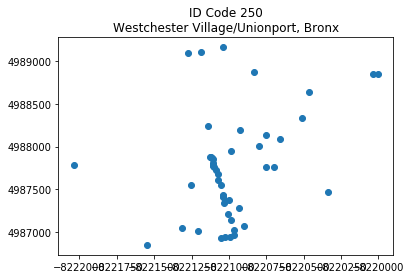

Midtown East, Manhattan


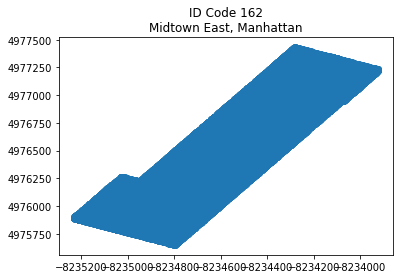

Clinton Hill, Brooklyn


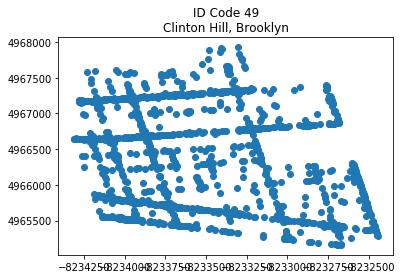

Seaport, Manhattan


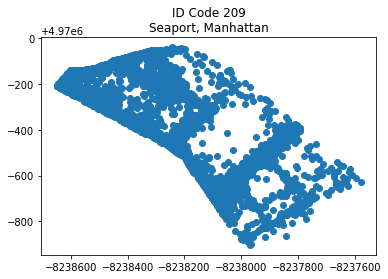

Crotona Park, Bronx


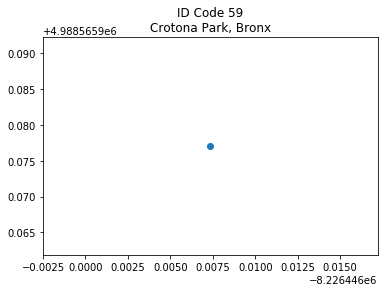

Washington Heights South, Manhattan


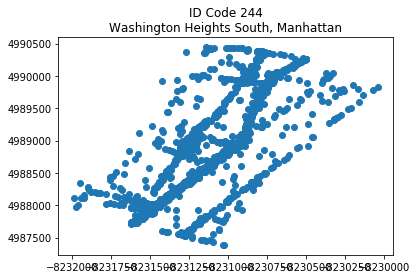

In [28]:
for ind, id_code in enumerate(id_points_to_plot.tolist()):
    plt.figure(ind)
    id_df = df1.loc[df1['pickup_id'] == id_code]
    points_x, points_y = zip(*id_df['pickup_merc_x_y'])
    
    plt.scatter(points_x, points_y)

    region = taxi_zone_df.loc[taxi_zone_df['LocationID'] == id_code, 'Borough'].iloc[0]
    neighborhood = taxi_zone_df.loc[taxi_zone_df['LocationID'] == id_code, 'Zone'].iloc[0]

    plt.title('ID Code ' + str(int(id_code)) + '\n' + neighborhood + ', ' + region)
    print(neighborhood + ', ' + region)
    plt.show()

## As we can see, this data may work well with kmeans/gmm/spectral clustering. 
## We don't know... Let's run both and look at the results. Maybe it doesn't matter.

## Check this link for a quick comparison between clustering algorithms
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## Some other links for reference
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

## K Means

In [58]:
kmeans_df = taxi_zone_df.drop(['service_zone'], axis=1)
kmeans_df['ClusterSize'] = None
kmeans_df['ClusterGlobalIDs'] = None
kmeans_df['KmeansMSE'] = None

print(kmeans_df.head())

   LocationID        Borough                     Zone ClusterSize  \
0           1            EWR           Newark Airport        None   
1           2         Queens              Jamaica Bay        None   
2           3          Bronx  Allerton/Pelham Gardens        None   
3           4      Manhattan            Alphabet City        None   
4           5  Staten Island            Arden Heights        None   

  ClusterGlobalNewIDs KmeansMSE  
0                None      None  
1                None      None  
2                None      None  
3                None      None  
4                None      None  


In [60]:
clusters_dict = dict()
global_cluster_id = 0
num_clusters = 10
cluster_id = np.zeros((len(  df),))

for large_id in range(280):
    if large_id % 10 == 0:
        print("Finished clustering up to id:", large_id)
    df_of_id = df.loc[df['pickup_id'] == large_id]
    if not df_of_id.empty:
        PU_merc_of_id = np.stack(df_of_id['pickup_merc_x_y'].values, axis=0)
        if len(PU_merc_of_id) >= num_clusters:
            kmeans = KMeans(n_clusters=num_clusters, n_jobs=-1).fit(PU_merc_of_id)
            cluster_centroids = kmeans.cluster_centers_
            labels = kmeans.labels_
            
            # inserting the cluster size into the kmeans dataframe
            kmeans_df.loc[kmeans_df.LocationID == large_id, 'ClusterSize'] = num_clusters
            
            # inserting the cluster error into the kmeans dataframe
            kmeans_df.loc[kmeans_df.LocationID == large_id, 'KmeansMSE'] = kmeans.inertia_
        else:
            cluster_centroids = PU_merc_of_id
            labels = np.asarray(range(len(cluster_centroids)))
            
            # inserting the cluster size into the kmeans dataframe
            kmeans_df.loc[kmeans_df.LocationID == large_id, 'ClusterSize'] = len(cluster_centroids)
            kmeans_df.loc[kmeans_df.LocationID == large_id, 'KmeansMSE'] = 0.0

        clusters_in_large_id = []
        for k, cluster in enumerate(cluster_centroids):
            clusters_dict[global_cluster_id] = cluster
            k_group = df_of_id.loc[labels==k]
            k_group_i = k_group.index.values
            cluster_id[k_group_i] = global_cluster_id
            clusters_in_large_id.append(global_cluster_id)
            global_cluster_id += 1

            # inserting the cluster dictionary keys into the kmeans dataframe
        kmeans_df.loc[kmeans_df.LocationID == large_id, 'ClusterGlobalIDs'] = pd.Series(clusters_in_large_id)

df['cluster_id'] = cluster_id.astype('int')

Finished clustering up to id: 0
Finished clustering up to id: 10
Finished clustering up to id: 20
Finished clustering up to id: 30
Finished clustering up to id: 40
Finished clustering up to id: 50
Finished clustering up to id: 60
Finished clustering up to id: 70
Finished clustering up to id: 80
Finished clustering up to id: 90
Finished clustering up to id: 100
Finished clustering up to id: 110
Finished clustering up to id: 120
Finished clustering up to id: 130
Finished clustering up to id: 140
Finished clustering up to id: 150
Finished clustering up to id: 160
Finished clustering up to id: 170
Finished clustering up to id: 180
Finished clustering up to id: 190
Finished clustering up to id: 200
Finished clustering up to id: 210
Finished clustering up to id: 220
Finished clustering up to id: 230
Finished clustering up to id: 240
Finished clustering up to id: 250
Finished clustering up to id: 260
Finished clustering up to id: 270


In [64]:
print(df.head())
print(kmeans_df.head())

   dropoff_id  dropoff_latitude  dropoff_longitude  \
0       162.0         40.758575         -73.971850   
1       141.0         40.767979         -73.956632   
2       114.0         40.728221         -73.999390   
3       162.0         40.754197         -73.975601   
4       164.0         40.746460         -73.989663   

                           dropoff_merc_x_y  fare_amount  pickup_id  \
0   (-8234508.675036414, 4976796.485561519)          8.5       50.0   
1   (-8232814.615025521, 4978178.621231795)          4.0      263.0   
2   (-8237574.413812861, 4972336.595569553)         11.0       48.0   
3  (-8234926.2344463775, 4976153.103735587)          5.5      170.0   
4   (-8236491.609125912, 4975016.193801009)          6.5      161.0   

   pickup_latitude  pickup_longitude                          pickup_merc_x_y  \
0        40.762503        -73.993487  (-8236917.294858707, 4977373.772382576)   
1        40.773923        -73.954618  (-8232590.417571062, 4979052.330627303)   
2    

Park Slope, Brooklyn


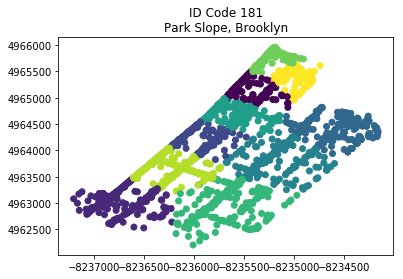

Jackson Heights, Queens


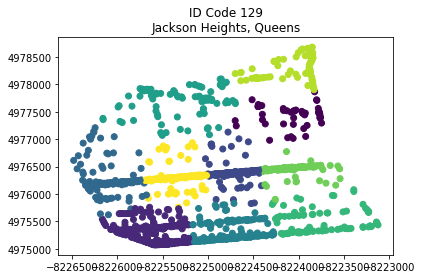

Laurelton, Queens


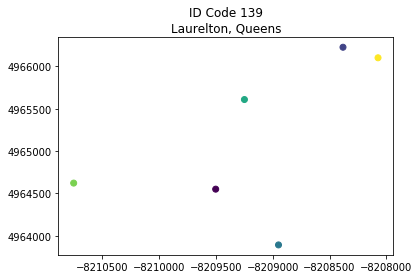

Prospect Park, Brooklyn


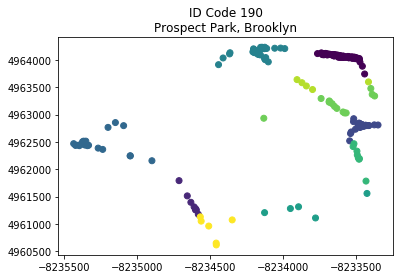

Westchester Village/Unionport, Bronx


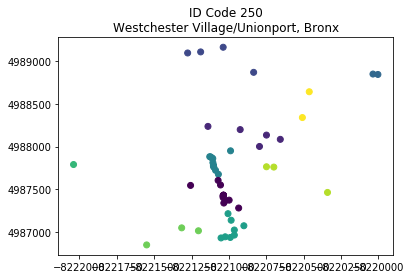

Midtown East, Manhattan


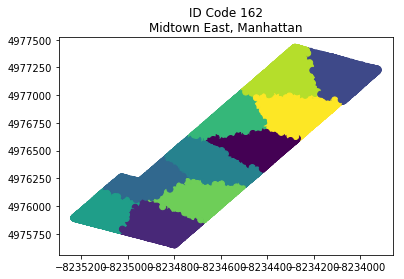

Clinton Hill, Brooklyn


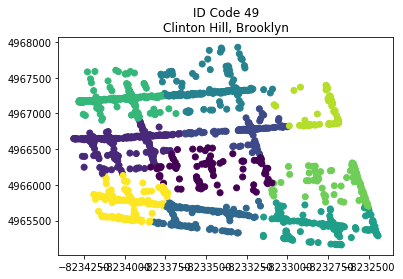

Seaport, Manhattan


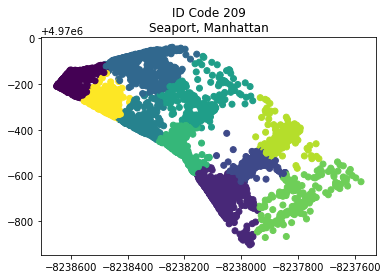

Crotona Park, Bronx


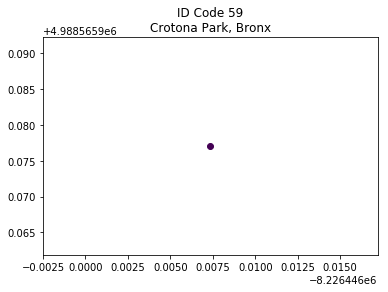

Washington Heights South, Manhattan


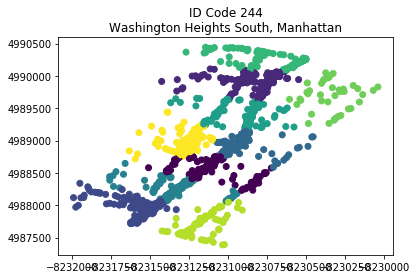

In [68]:
for ind, id_code in enumerate(id_points_to_plot.tolist()):
    plt.figure(ind)
    id_df = df.loc[df['pickup_id'] == id_code]
    points_x, points_y = zip(*id_df['pickup_merc_x_y'])
    cluster_labels = id_df['cluster_id']
    
    plt.scatter(points_x, points_y, c=cluster_labels)
    
    region = taxi_zone_df.loc[taxi_zone_df['LocationID'] == id_code, 'Borough'].iloc[0]
    neighborhood = taxi_zone_df.loc[taxi_zone_df['LocationID'] == id_code, 'Zone'].iloc[0]
    
    plt.title('ID Code ' + str(int(id_code)) + '\n' + neighborhood + ', ' + region)
    print(neighborhood + ', ' + region)
    plt.show()